<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/Grid_Test_Knock_Out_Call_1stock_Old_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(0.5, 1.0, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(B_range)
print(sigma_range)
print(r_range)

[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.75       0.82142854 0.89285713 0.9642857  1.0357143  1.1071429
 1.1785713  1.25      ]
[0.5        0.5714286  0.6428572  0.71428573 0.78571427 0.85714287
 0.92857146 1.        ]
[0.15       0.25       0.35000002 0.45      ]
[0.01  0.025 0.04 ]


In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(0.5, 1.0, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []
count = 0

for S in S_range:
  for K in K_range:
    for B in B_range:
      for r in r_range:
        for sigma in sigma_range:    

          initial_stocks = jnp.array([S]*numstocks) # must be float
          r_tmp = jnp.array([r]*numstocks)
          drift = r_tmp
          cov = jnp.identity(numstocks)*sigma*sigma

          Knock_Out_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          call.append([T, K, B, S, sigma, r, r, Knock_Out_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
          
          count += 1
          print(count)

Streaming output truncated to the last 5000 lines.
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870

In [ ]:
Thedataset = pd.DataFrame(call)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.048392188,0.556177
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.07790985,0.564888
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.10672783,0.573440
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.1332959,0.571065
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.054101802,0.595272
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.20006092,0.472318
7676,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.10021045,0.632276
7677,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.14452648,0.584406
7678,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.180067,0.530899


In [ ]:
# save to csv
Thedataset.to_csv('Knock_Out_Call_1stock_MC_Datset_v3.csv', index=False, header=False)

In [2]:
# read csv
import pandas as pd

Thedataset = pd.read_csv('Knock_Out_Call_1stock_MC_Datset_v2.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.048298,0.555157
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.077764,0.563845
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.106536,0.572229
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.133061,0.569618
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.053998,0.594301
...,...,...,...,...,...,...,...,...,...
2395,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.199720,0.471407
2396,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.100027,0.631672
2397,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.144241,0.583131
2398,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.179728,0.529840


# Construct Neural Net

In [3]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7]
Thedataset_Y = Thedataset.iloc[:,7:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
ds = OptionDataSet(max_len = 1)
for i in ds:
    print(i[0])
    print(i[0].shape)
    print(i[1])
    print(i[1].shape)

tensor([[1.000000, 0.750000, 0.500000,  ..., 0.150000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.500000,  ..., 0.250000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.500000,  ..., 0.350000, 0.010000, 0.010000],
        ...,
        [1.000000, 1.250000, 1.000000,  ..., 0.250000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.000000,  ..., 0.350000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.000000,  ..., 0.450000, 0.040000, 0.040000]],
       device='cuda:0', dtype=torch.float64)
torch.Size([2400, 7])
tensor([[0.048298, 0.555157],
        [0.077764, 0.563845],
        [0.106536, 0.572229],
        ...,
        [0.144241, 0.583131],
        [0.179728, 0.529840],
        [0.206979, 0.482881]], device='cuda:0', dtype=torch.float64)
torch.Size([2400, 2])


In [4]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*1, 64) # remember to change this!
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.5, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 8.0 MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_knock_out_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.10698648630243734 average time 0.002900862999979381 iter num 20
loss 0.05522558757449096 average time 0.0027096747499967934 iter num 40
loss 0.0506198174084719 average time 0.002612312600012956 iter num 60
loss 0.04804833234815817 average time 0.00252532212501535 iter num 80
loss 0.047562658601596815 average time 0.0024670609800136844 iter num 100
loss 0.0373773328731081 average time 0.002704608800013375 iter num 20
loss 0.0265012769595068 average time 0.002492601450001075 iter num 40
loss 0.018986157805203817 average time 0.0024652872333338865 iter num 60
loss 0.016067767677562655 average time 0.002547629724995204 iter num 80
loss 0.015540427544867036 average time 0.002611855589989318 iter num 100
loss 0.010456275580886713 average time 0.0027305932499871234 iter num 20
loss 0.010240173262536966 average time 0.002657736050014137 iter num 40
loss 0.010117409029571468 average time 0.0025617063166881358 iter num 60
loss 0.010089131806297405 average time 0.00255284632501116 iter num

In [ ]:
# 

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_out_1stock_densergrid_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_out_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)


**Continue to train model**

In [ ]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-4, amsgrad=True) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.035923793568878065 average time 2.1161620507499945 iter num 20
loss 0.0359088227884686 average time 2.117986477250014 iter num 40
loss 0.035898869725666846 average time 2.119290947166682 iter num 60
loss 0.03589445991231862 average time 2.1167064351750016 iter num 80
loss 0.035893525670518685 average time 2.1163014866000003 iter num 100
loss 0.035876145018231706 average time 2.130255113499993 iter num 20
loss 0.03586071681304882 average time 2.1185614623999696 iter num 40
loss 0.035850518773534526 average time 2.122669476816653 iter num 60
loss 0.03584589810408316 average time 2.1214107102499953 iter num 80
loss 0.03584492107817007 average time 2.124587830999994 iter num 100
loss 0.035826937819412166 average time 2.1230099534999907 iter num 20
loss 0.035811238762083926 average time 2.1204493999750014 iter num 40
loss 0.03580098220655523 average time 2.119429244066661 iter num 60
loss 0.035796379485267794 average time 2.1215808921000017 iter num 80
loss 0.03579542667373802 averag

In [ ]:
# 12:00

#Results

In [11]:
import torch
inputs = torch.tensor([[1, 1, 0.8, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, B, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

# price, delta
# should be around (0.10632345, 0.5543747)

price: tensor([[0.105575, 0.552728]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [13]:
# Knock out call

# now change code such that 'numsteps' does not represent year
# make dt = year / numsteps
# Add r, and notice that noise must have mean 0, not drift, or else it'll give large option prices
# (done)
# after making the changes, the values are still correct

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(1)
rng, key = jax.random.split(rng)

drift = jnp.array([0.02]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0
B = 0.8 # if B is set to 0, equivalent to European call

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

0.10632345
[0.5543747]


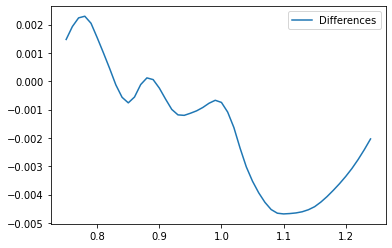

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def compute_price(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "correct_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

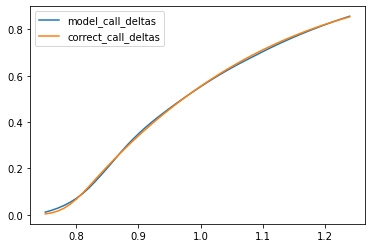

In [23]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.0, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

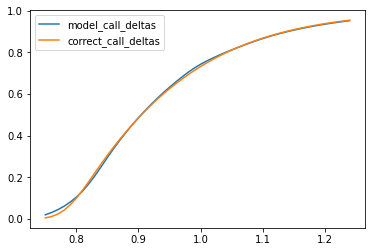

In [24]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 0.775, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

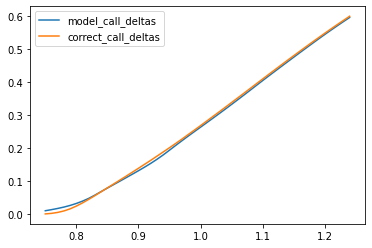

In [25]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.225, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()